# Case study: Drug sale forecasting

## Setup

In [1]:
## Bibliotecas
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Estilos para os gráficos
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

## A. Data Collection

**M01AB** - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

In [3]:
# definindo caminho do arquivo
PATH = "datasets/salesdaily.csv"

# escolhendo target
TARGET = "M01AB"

# definindo coluna de data
DATE_COLUMN = "datum"

# Carregamento dos dados
df = pd.read_csv(PATH)

# Convertendo datas
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Selecionando colunas
df = df[[DATE_COLUMN, TARGET]]

# Preenchendo nulos com a média
df = df.fillna(method="ffill")

# Escolha da granularidade (diária)
df = df[[DATE_COLUMN,TARGET]].groupby(DATE_COLUMN).sum()

df

,M01AB
datum,
2014-01-02,0.00
2014-01-03,8.00
2014-01-04,2.00
2014-01-05,4.00
2014-01-06,5.00
...,...
2019-10-04,7.34
2019-10-05,3.84
2019-10-06,4.00


In [4]:
train = df[TARGET][:(int(df.shape[0] * 0.7))]
test = df[TARGET][(int(df.shape[0] * 0.7)):]

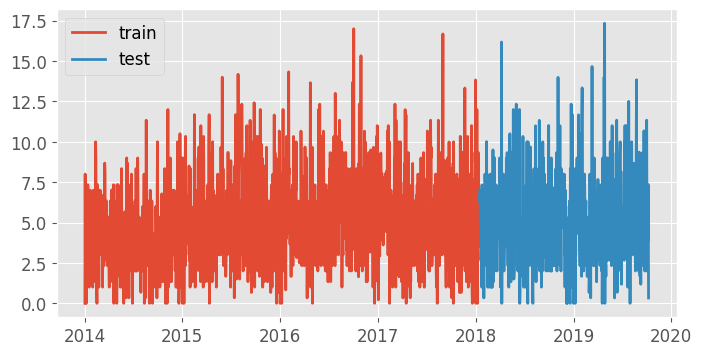

In [5]:
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.legend()
plt.show()

## B. Stationary Test

In [6]:
result = adfuller(df[TARGET].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.279357
p-value: 0.000000


Como p-value é baixo, não é necessário fazer a diferenciação da série. Isso implica que o modelo ARIMA(p,d,q) terá d=0.

## C. Model Identification and Selection

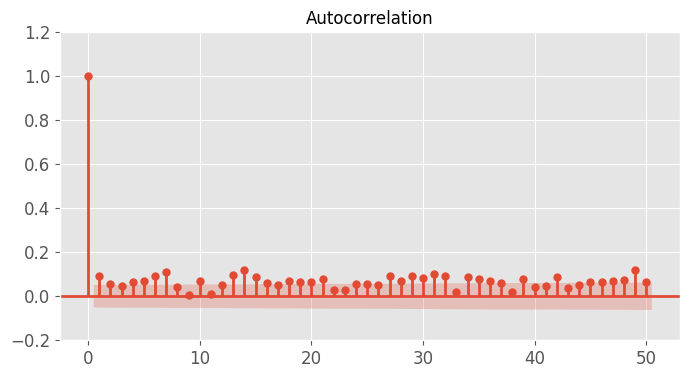

In [7]:
# ACF
sm.graphics.tsa.plot_acf(train.dropna().values.squeeze(), lags=50)
plt.ylim(-0.2,1.2)
plt.show()

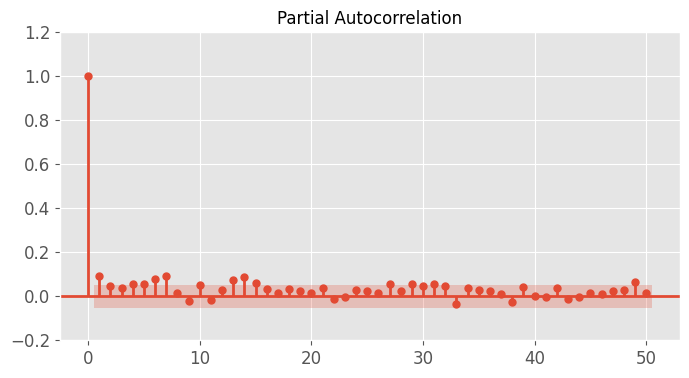

In [8]:
# PACF
sm.graphics.tsa.plot_pacf(
    train.dropna().values.squeeze(), 
    method='ywm',
    lags=50)
plt.ylim(-0.2,1.2)
plt.show()

Para AR escolheremos p=1 e para MA escolheremos q=7.

In [9]:
model = ARIMA(train, order=(1,0,1)) # 1, 0, 1 # 0, 0, 60
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  M01AB   No. Observations:                 1474
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3519.510
Date:                Thu, 13 Apr 2023   AIC                           7047.019
Time:                        11:56:19   BIC                           7068.202
Sample:                    01-02-2014   HQIC                          7054.918
                         - 01-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8936      0.431     11.342      0.000       4.048       5.739
ar.L1          0.9972      0.002    409.096      0.000       0.992       1.002
ma.L1         -0.9801      0.007   -143.202      0.0

## D. Model Diagnostic

Ljung-Box (L1) (Q): 0

H0: The residuals are independently distributed.

HA: The residuals are not independently distributed; they exhibit serial correlation.

Concluímos que os resíduos são independente distribuídos e, portanto, o modelo é válido.

## E. Forecasting

In [10]:
pred = model_fit.forecast(20, alpha=0.05) # 20 valores

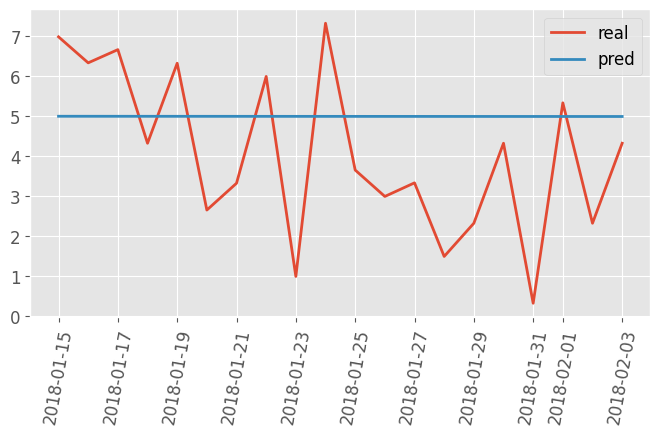

In [11]:
test_horizon = test[:20]

plt.plot(test_horizon.index, test_horizon, label='real')
plt.plot(pred.index, pred, label='pred')
plt.legend()
plt.xticks(rotation=80)
plt.show()

### Errors

In [12]:
mean_absolute_error(pred, test_horizon)

1.9261509602299143

In [13]:
pd.DataFrame({
    'Day': test_horizon.index,
    'Prediction': pred.values,
    'Real': test_horizon.values
})

,Day,Prediction,Real
0,2018-01-15,5.004520,6.99
1,2018-01-16,5.004204,6.34
2,2018-01-17,5.003889,6.67
3,2018-01-18,5.003574,4.33
4,2018-01-19,5.003261,6.33
5,2018-01-20,5.002949,2.66
6,2018-01-21,5.002637,3.33
7,2018-01-22,5.002327,6.00
8,2018-01-23,5.002017,1.00
9,2018-01-24,5.001708,7.33


## Auto-Arima

In [14]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, d=1, max_p=9, max_q=9, suppress_warnings=True)  
forecaster.fit(train)  

AutoARIMA(d=1, max_p=9, max_q=9, sp=12, suppress_warnings=True)

In [15]:
y_pred = forecaster.predict(fh=list(range(1,21)))  

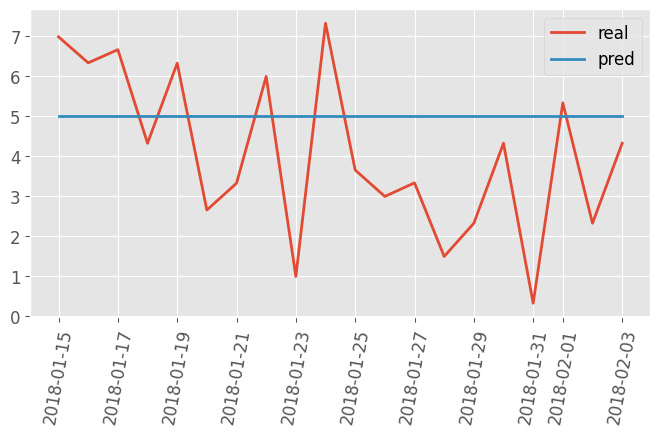

In [16]:
test_horizon = test[:20]

plt.plot(test_horizon.index, test_horizon, label='real')
plt.plot(y_pred.index, y_pred, label='pred')
plt.legend()
plt.xticks(rotation=80)
plt.show()

In [17]:
mean_absolute_error(y_pred, test_horizon)

1.9305632349229895

## Prophet

In [18]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(  
    seasonality_mode='multiplicative',
    n_changepoints=int(len(train) / 7),
    add_country_holidays={'country_name': 'Brazil'},
    yearly_seasonality=True)
forecaster.fit(train)  

Importing plotly failed. Interactive plots will not work.
11:56:31 - cmdstanpy - INFO - Chain [1] start processing
11:56:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'Brazil'}, n_changepoints=210,
        seasonality_mode='multiplicative', yearly_seasonality=True)

In [19]:
y_pred = forecaster.predict(fh=list(range(1,21)))  

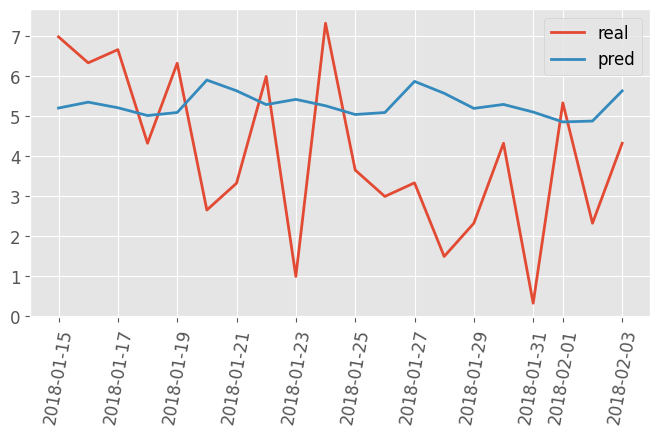

In [20]:
test_horizon = test[:20]

plt.plot(test_horizon.index, test_horizon, label='real')
plt.plot(y_pred.index, y_pred, label='pred')
plt.legend()
plt.xticks(rotation=80)
plt.show()

In [21]:
mean_absolute_error(y_pred, test_horizon)

2.0979148138961223

## Suavizamento exponencial

In [22]:
from sktime.forecasting.exp_smoothing  import ExponentialSmoothing
forecaster = ExponentialSmoothing()
forecaster.fit(train)

ExponentialSmoothing()

In [23]:
pred = forecaster.predict(fh=list(range(1,21)))  

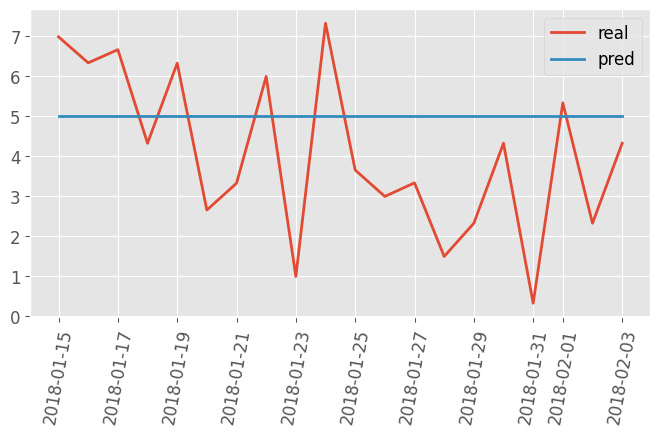

In [24]:
test_horizon = test[:20]

plt.plot(test_horizon.index, test_horizon, label='real')
plt.plot(pred.index, pred, label='pred')
plt.legend()
plt.xticks(rotation=80)
plt.show()

In [25]:
mean_absolute_error(pred, test_horizon)

1.929705128524293